# Preparing Data

**GOALS:**


1.   Process all the data sets and narrow them down to only CS related.
2.   Train data on neural network (MLP).
3.   Get some images/plots going.



## Importing Data

First, we will import our input data set and the solution data set through kaggle. Then, we will read the data in as data tables.

In [ ]:
# importing data sets
import kagglehub

# importing path for resumes
# https://www.kaggle.com/datasets/suriyaganesh/resume-dataset-structured?select=05_person_skills.csv
path_input = kagglehub.dataset_download("suriyaganesh/resume-dataset-structured")

# importing path for the job descriptions
# https://www.kaggle.com/datasets/ravindrasinghrana/job-description-dataset
path_solution = kagglehub.dataset_download("ravindrasinghrana/job-description-dataset")

100%|██████████| 38.0M/38.0M [00:00<00:00, 179MB/s]

Extracting files...


100%|██████████| 457M/457M [00:03<00:00, 146MB/s]

Extracting files...


In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/My\ Drive/Group\ Project/computer_science_tech_job_titles.csv .
!cp /content/drive/My\ Drive/Group\ Project/cs_tech_keywords.csv .

In [ ]:
# importing data sets
import pandas as pd

# data for resumes
# resumes_01_people = pd.read_csv(f"{path_input}/01_people.csv") -- unnecessary
resumes_02_abilities = pd.read_csv(f"{path_input}/02_abilities.csv")
resumes_03_education = pd.read_csv(f"{path_input}/03_education.csv")
resumes_04_experience = pd.read_csv(f"{path_input}/04_experience.csv")
resumes_05_person_skills = pd.read_csv(f"{path_input}/05_person_skills.csv")
# resume_06_skills = pd.read_csv(f"{path_input}/06_skills.csv") -- unnecessary


# data for the job descriptions
job_descriptions = pd.read_csv(f"{path_solution}/job_descriptions.csv")

# 1000 computer science tech jobs generated by ChatGPT
cs_tech_job_titles = pd.read_csv("computer_science_tech_job_titles.csv")

# cs and tech related keywords generated by ChatGPT
cs_tech_keywords = pd.read_csv("cs_tech_keywords.csv")


In [ ]:
# getting size of data
print(job_descriptions.shape)

# it should be noted that the rows for this data set is not unique so we need to merge them
# an idea is that we can group all strings with same person_id
print(resumes_02_abilities.shape)
print(resumes_03_education.shape)
print(resumes_04_experience.shape)
print(resumes_05_person_skills.shape)

(1615940, 23)
(1219473, 2)
(75999, 5)
(265404, 6)
(2483376, 2)


## Scaling Data Down





Next, we need to scale down the input data and solution set so it only has tech related jobs. We also need to narrow down columns within the data sets so it includes only the most important features.

We will start by scaling down the number of rows and columns.


In [ ]:
# downsizing the data sets so it runs more smoothly -- we will use the first 10000 rows
job_descriptions_10k = job_descriptions.loc[:9999, ["Job Id", "Experience", "Qualifications", "Job Title", "skills", "Responsibilities"]]

# merge rows with same person_id for resume data set
resumes_abilities_10k = resumes_02_abilities.groupby("person_id", as_index = False).agg({"ability": lambda x: ", ".join(set(x.dropna().astype(str)))}).iloc[:10000, :]
resumes_education_10k = resumes_03_education.groupby("person_id", as_index = False).agg({"program": lambda x: ", ".join(set(x.dropna().astype(str)))}).iloc[:10000, :]
resumes_experience_10k = resumes_04_experience.groupby("person_id", as_index = False).agg({"title": lambda x: ", ".join(set(x.dropna().astype(str)))}).iloc[:10000, :]
resumes_person_skills_10k = resumes_05_person_skills.groupby("person_id", as_index = False).agg({"skill": lambda x: ", ".join(set(x.dropna().astype(str)))}).iloc[:10000, :]

# may have to merge rows for job descriptions as well to make job_id unique -- if it isn't already

In [ ]:
# new shape of data set
print(job_descriptions_10k.shape)

print(resumes_abilities_10k.shape)
print(resumes_education_10k.shape)
print(resumes_experience_10k.shape)
print(resumes_person_skills_10k.shape)

(10000, 6)
(10000, 2)
(10000, 2)
(10000, 2)
(10000, 2)


In [ ]:
# merging resumes into one data frame
resumes_10k = (resumes_abilities_10k.merge(resumes_education_10k, on = "person_id", how = "left")
                                    .merge(resumes_experience_10k, on = "person_id", how = "left")
                                    .merge(resumes_person_skills_10k, on = "person_id", how = "left")
)

resumes_10k.columns

Index(['person_id', 'ability', 'program', 'title', 'skill'], dtype='object')

### Embeddings


Next, we will use text [embeddings](https://stackoverflow.blog/2023/11/09/an-intuitive-introduction-to-text-embeddings/) to filter the data sets so only CS tech jobs and resumes remain. We will use the [SentenceTransformers](https://www.sbert.net/) Python Module, but we could also use OpenAI's [embedding model](https://platform.openai.com/docs/guides/embeddings).



In [ ]:
# installations
!pip install torch==2.5.0 torchvision==0.20.0 torchaudio==2.5.0 --index-url https://download.pytorch.org/whl/cu121
!pip install -U sentence-transformers


Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.4/780.4 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 132.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 114.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 111.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 60.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 127.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 530.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 796.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/1

In [ ]:
# narrowing down the scope of the data sets so it only has CS related jobs and resumes

from sentence_transformers import SentenceTransformer
import numpy as np

# the model uses a vector space to map similar pieces of text close to each other, while others are further away
model = SentenceTransformer("all-MiniLM-L6-v2")

In [ ]:
# we need to create a reference vector that will be used to filter our data sets
keywords_embeddings = model.encode(cs_tech_keywords.iloc[:, 0].tolist())
job_titles_embeddings = model.encode(cs_tech_job_titles.iloc[:, 0].tolist())

ref_embeddings = np.mean(np.vstack([keywords_embeddings, job_titles_embeddings]), axis = 0).flatten()

# encoding job descriptions data set
temp1 = job_descriptions_10k.loc[:, ["Job Title", "skills", "Responsibilities"]].astype(str).agg(", ".join, axis = 1)
job_descriptions_10k_embedding = model.encode(temp1)

# encoding resumes data set
temp2 = resumes_10k.loc[:, ["ability", "program", "title", "skill"]].astype(str).agg(", ".join, axis = 1)
resumes_10k_embedding = model.encode(temp2)

# normalizing embeddings
ref_embeddings /= np.linalg.norm(ref_embeddings)
job_descriptions_10k_embedding /= np.linalg.norm(job_descriptions_10k_embedding, axis = 1, keepdims = True)
resumes_10k_embedding /= np.linalg.norm(resumes_10k_embedding, axis = 1, keepdims = True)

# checking similarities
jobs_similarities = job_descriptions_10k_embedding.dot(ref_embeddings)
resumes_similarities = resumes_10k_embedding.dot(ref_embeddings)


In [ ]:
for i in range(30):
  print(str(jobs_similarities[i]) + "    " + temp1.iloc[i])

# threshold for job descriptions
job_threshold = 0.375

0.2601987    Digital Marketing Specialist, Social media platforms (e.g., Facebook, Twitter, Instagram) Content creation and scheduling Social media analytics and insights Community engagement Paid social advertising, Manage and grow social media accounts, create engaging content, and interact with the online community. Develop social media content calendars and strategies. Monitor social media trends and engagement metrics.
0.40650284    Web Developer, HTML, CSS, JavaScript Frontend frameworks (e.g., React, Angular) User experience (UX), Design and code user interfaces for websites, ensuring a seamless and visually appealing user experience. Collaborate with UX designers to optimize user journeys. Ensure cross-browser compatibility and responsive design.
0.39264882    Operations Manager, Quality control processes and methodologies Statistical process control (SPC) Root cause analysis and corrective action Quality management systems (e.g., ISO 9001) Compliance and regulatory knowledge, 

In [ ]:
for i in range(30):
  print(str(resumes_similarities[i]) + "    " + temp2.iloc[i])

# threshold for resumes -- may have to fix/come back to get better threshold embeddings
# may be skewed because most of the resume data is already tech related
resume_threshold = 0.35

0.39676645    and ability to work in a team, troubleshooting, monitoring, and, Highly motivated self-starter with, /2008R2R2/2012/2014, MS SQL Server 2005/2008, Support various MS SQL Server, performance tuning, capacity, SQL code., virtual environment., planning, SQL Server clustering,, creation/alteration, grant of, managing SQL databases in a, communication skills, work ethics, Installation and Building Server, Familiar with virtualization and, recovery testing and documenting, the deliverables., Excellent analytical,, determination and commitment to, on various database objects., well as with SQL Server 2012 on, system/DB roles and permissions, database security configuration,, production)., Recovering and Restoring Models, Running Backups, recovery scenarios., the ability to work independently., 201, databases for mission-critical, Manage the production and, recovery., Use SQL Profiler for, business., environments from SQL Server, and database continuity., Perform routine backup a

### Filtering

Finally, after we finish the embeddings, we can filter our 10k data sets down to the final data sets that will be used for training and testing our models.

In [ ]:
# filtering to get final data sets
job_mask = jobs_similarities >= job_threshold
resume_mask = resumes_similarities >= resume_threshold

cs_tech_jobs = job_descriptions_10k[job_mask]
cs_tech_resumes = resumes_10k[resume_mask]

print(cs_tech_jobs.shape)
print(cs_tech_resumes.shape)

(3217, 6)
(7847, 5)


In [ ]:
print(cs_tech_jobs.columns)
print(cs_tech_resumes.columns)

Index(['Job Id', 'Experience', 'Qualifications', 'Job Title', 'skills',
       'Responsibilities'],
      dtype='object')
Index(['person_id', 'ability', 'program', 'title', 'skill'], dtype='object')


**NOTE:** There is the possibility that our final data sets include non-tech and non-cs jobs and resumes that managed to get past our filtering (we will need to revisit the filterting and make it more accurate).

# Training Models

**IDEA:** For our feedback system, we could possible provide feedback on their resume and experience/technical skills using text embeddings. For example: we could compare a job description from job descriptions data set and a resume from our resumes data set, and see whether the similarities between them.

## Embedding Input Data

In [ ]:
cs_tech_jobs_all = cs_tech_jobs.fillna("").astype(str).agg(", ".join, axis = 1)
cs_tech_jobs_embeddings = model.encode(cs_tech_jobs_all.tolist())

cs_tech_resumes_all = cs_tech_resumes.fillna("").astype(str).agg(", ".join, axis = 1)
cs_tech_resumes_embeddings = model.encode(cs_tech_resumes_all.tolist())

## Binary Classification for Job Interview

We can start by using a binary classification to determine if a resume will get an interview or not for a job.

### Gemini Labeling

Here, we use Gemini to generate labels.

In [ ]:
import getpass
import os

os.environ["GEMINI_API_KEY"] = getpass.getpass("Gemini API key: ")

Gemini API key: ··········


In [ ]:
from google import genai
from google.genai import types

client = genai.Client(api_key = os.environ["GEMINI_API_KEY"])

In [ ]:
def pair_labels(resume_id, job_id, resume_text, job_text):
  prompt = f"""
    You are an expert recruiter for tech-related and cs-related jobs. Given a candidate's resume and a job description,
    rate how likely the candidate is to get an interview for the job with either 1 or 0:
      - 1 means they will get the interview.
      - 0 means they will not get the interview.

    Return your answer strictly as either 1 or 0.
  """

  content = f"""
    Resume: {resume_text}
    Job Description: {job_text}
  """

  response = client.models.generate_content(
    model = "gemini-2.5-flash-lite",
    config = types.GenerateContentConfig(
      system_instruction = prompt),
    contents = content,
  )

  score = int(response.text.strip())

  return {
    "resume_id": resume_id,
    "job_id": job_id,
    "score": score
  }

Here, we filter more and select the top 20 resumes for each job to use to construct our labels. We only select the top 20 to make it easier to generate the labels since it takes a lot of time to run a prompt.

NOTE: We may need to make it more narrow and filter more, since it still takes too long to run.

In [ ]:
# cutting off job descriptions to make runtime shorter

cs_jobs = cs_tech_jobs_all[:50]
cs_jobs_embeddings = model.encode(cs_jobs.tolist())

In [ ]:
resumes = [
  {
      "id": rid,
      "text": text,
      "embedding": emb
  }
  for rid, text, emb in zip(cs_tech_resumes['person_id'], cs_tech_resumes_all, cs_tech_resumes_embeddings)
]

jobs = [
  {
      "id": jid,
      "text": text,
      "embedding": emb
  }
  for jid, text, emb in zip(cs_tech_jobs['Job Id'], cs_jobs, cs_jobs_embeddings)
]

In [ ]:
top = 25
selected_pairs = []

# filtering top 25 resumes
for j in jobs:
  job_vec = j["embedding"]
  sims = np.array([np.dot(r["embedding"], job_vec) / (np.linalg.norm(r["embedding"]) * np.linalg.norm(job_vec)) for r in resumes])

  top_indices = sims.argsort()[-top:][::-1]

  for idx in top_indices:
    selected_pairs.append((resumes[idx], j))

In [ ]:
# checking that our pairs are unique
for p in selected_pairs:
  print(p[0]["id"], p[1]["id"])

5372 398454096642776
5395 398454096642776
4793 398454096642776
5346 398454096642776
5405 398454096642776
3488 398454096642776
5783 398454096642776
5339 398454096642776
5768 398454096642776
5564 398454096642776
5587 398454096642776
3768 398454096642776
4087 398454096642776
4447 398454096642776
4978 398454096642776
5047 398454096642776
4282 398454096642776
5353 398454096642776
4194 398454096642776
5274 398454096642776
3481 398454096642776
4537 398454096642776
5397 398454096642776
5367 398454096642776
5375 398454096642776
7982 481640072963533
1445 481640072963533
7747 481640072963533
8219 481640072963533
9714 481640072963533
6506 481640072963533
6859 481640072963533
575 481640072963533
9902 481640072963533
8751 481640072963533
935 481640072963533
6182 481640072963533
2648 481640072963533
7801 481640072963533
7601 481640072963533
6673 481640072963533
8073 481640072963533
7428 481640072963533
855 481640072963533
9940 481640072963533
1739 481640072963533
8918 481640072963533
7186 48164007296

In [ ]:
print(len(selected_pairs))

1250


In [ ]:
import time

labels = []

total_time = 0
for i in range(len(selected_pairs)):
  start_time = time.time()
  r = selected_pairs[i][0]   # resume
  j = selected_pairs[i][1]   # job

  # retries the API call for 2 minutes if the call fail - retries API call on fail after 5 seconds
  while(time.time() - start_time <= 120):
    try:
      labels.append(pair_labels(r['id'], j['id'], r['text'], j['text']))
      end_time = time.time()
      total_time += end_time - start_time
      avg_time = total_time / (i + 1)
      print("execution time: " + str(end_time-start_time) + " total %: " + str(float(i/len(selected_pairs)*100)) + " predicted total time (m): " + str(avg_time*len(selected_pairs) / 60))
      break
    except Exception as e:
      print(e)
      time.sleep(30)

execution time: 0.5863683223724365 total %: 0.0 predicted total time (m): 12.216006716092428
execution time: 0.40921807289123535 total %: 0.08 predicted total time (m): 10.370691617329916
execution time: 0.44110894203186035 total %: 0.16 predicted total time (m): 9.977050953441196
execution time: 0.382157564163208 total %: 0.24 predicted total time (m): 9.473192195097605
execution time: 0.49138474464416504 total %: 0.32 predicted total time (m): 9.625990192095438
execution time: 0.4524803161621094 total %: 0.4 predicted total time (m): 9.592770702309078
execution time: 0.4875006675720215 total %: 0.48 predicted total time (m): 9.673269731657847
execution time: 0.42402076721191406 total %: 0.5599999999999999 predicted total time (m): 9.568331763148308
execution time: 0.39779019355773926 total %: 0.64 predicted total time (m): 9.42599442270067
execution time: 0.39557766914367676 total %: 0.72 predicted total time (m): 9.307515124479929
execution time: 0.36553430557250977 total %: 0.8 pre

### Testing and Training Data

Next, we get the data arrays here and then split it into training and testing.

In [ ]:
print(labels)

[{'resume_id': 5372, 'job_id': 398454096642776, 'score': 0}, {'resume_id': 5395, 'job_id': 398454096642776, 'score': 1}, {'resume_id': 4793, 'job_id': 398454096642776, 'score': 1}, {'resume_id': 5346, 'job_id': 398454096642776, 'score': 1}, {'resume_id': 5405, 'job_id': 398454096642776, 'score': 1}, {'resume_id': 3488, 'job_id': 398454096642776, 'score': 1}, {'resume_id': 5783, 'job_id': 398454096642776, 'score': 1}, {'resume_id': 5339, 'job_id': 398454096642776, 'score': 1}, {'resume_id': 5768, 'job_id': 398454096642776, 'score': 1}, {'resume_id': 5564, 'job_id': 398454096642776, 'score': 1}, {'resume_id': 5587, 'job_id': 398454096642776, 'score': 1}, {'resume_id': 3768, 'job_id': 398454096642776, 'score': 1}, {'resume_id': 4087, 'job_id': 398454096642776, 'score': 1}, {'resume_id': 4447, 'job_id': 398454096642776, 'score': 1}, {'resume_id': 4978, 'job_id': 398454096642776, 'score': 1}, {'resume_id': 5047, 'job_id': 398454096642776, 'score': 1}, {'resume_id': 4282, 'job_id': 398454096

In [ ]:
print(cs_tech_jobs.loc[cs_tech_jobs['Job Id'] == 398454096642776])

            Job Id     Experience Qualifications      Job Title  \
1  398454096642776  2 to 12 Years            BCA  Web Developer   

                                              skills  \
1  HTML, CSS, JavaScript Frontend frameworks (e.g...   

                                    Responsibilities  
1  Design and code user interfaces for websites, ...  


In [ ]:
print(cs_tech_resumes.loc[cs_tech_resumes['person_id'] == 5346])

      person_id                                            ability  \
5344       5346  Developing appealing and user-friendly web and...   

                                          program                title  \
5344  Associate of Science in Computer Programmer  Front End Developer   

                                                  skill  
5344  Final Cut Pro, PHP, Adobe Photoshop, Wordpress...  


In [ ]:
for i in range(len(labels)):
  print(labels[i]['resume_id'], labels[i]['job_id'], labels[i]['score'])

5372 398454096642776 0
5395 398454096642776 1
4793 398454096642776 1
5346 398454096642776 1
5405 398454096642776 1
3488 398454096642776 1
5783 398454096642776 1
5339 398454096642776 1
5768 398454096642776 1
5564 398454096642776 1
5587 398454096642776 1
3768 398454096642776 1
4087 398454096642776 1
4447 398454096642776 1
4978 398454096642776 1
5047 398454096642776 1
4282 398454096642776 1
5353 398454096642776 1
4194 398454096642776 0
5274 398454096642776 1
3481 398454096642776 1
4537 398454096642776 1
5397 398454096642776 1
5367 398454096642776 1
5375 398454096642776 0
7982 481640072963533 0
1445 481640072963533 0
7747 481640072963533 0
8219 481640072963533 0
9714 481640072963533 0
6506 481640072963533 0
6859 481640072963533 0
575 481640072963533 0
9902 481640072963533 0
8751 481640072963533 0
935 481640072963533 0
6182 481640072963533 0
2648 481640072963533 0
7801 481640072963533 0
7601 481640072963533 0
6673 481640072963533 0
8073 481640072963533 0
7428 481640072963533 0
855 481640072

In [ ]:
cs_tech_resumes = cs_tech_resumes.reset_index(drop = True)
cs_tech_jobs = cs_tech_jobs.reset_index(drop = True)

In [ ]:
X = []
y = []
for i in range(len(labels)):
  resume_id = labels[i]['resume_id']
  job_id = labels[i]['job_id']

  r_indices = cs_tech_resumes.index[cs_tech_resumes['person_id'] == resume_id]
  j_indices = cs_tech_jobs.index[cs_tech_jobs['Job Id'] == job_id]

  X.append([cs_tech_resumes_embeddings[r_indices[0]], cs_tech_jobs_embeddings[j_indices[0]]])
  y.append(labels[i]['score'])

# X = np.hstack([cs_tech_resumes_embeddings[resume_index], cs_tech_jobs_embeddings[job_index]])

X = np.array(X)
y = np.array(y)

In [ ]:
print(y)

[0 1 1 ... 0 0 0]


In [ ]:
print(X.shape)
print(y.shape)

(1250, 2, 384)
(1250,)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

print(X_train.shape)
print(y_train.shape)

(1000, 2, 384)
(1000,)


### Random Forest Classifier

In [ ]:
from sklearn.decomposition import PCA

embedding1 = X_train[:, 0, :]
embedding2 = X_train[:, 1, :]
diff = embedding1 - embedding2
absdiff_train = np.abs(embedding1 - embedding2)

pca = PCA(n_components = 3)
X_train_reduced_full = pca.fit_transform(absdiff_train)

embedding1 = X_test[:, 0, :]
embedding2 = X_test[:, 1, :]
diff = embedding1 - embedding2
absdiff_test = np.abs(embedding1 - embedding2)

X_test_reduced_full = pca.transform(absdiff_test)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve

forest_clf = RandomForestClassifier(n_estimators = 100, random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train_reduced_full, y_train, cv = 3, n_jobs = -1, method = "predict_proba")

y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train, y_scores_forest)


In [ ]:
import matplotlib.pyplot as plt

def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize = 16)
    plt.ylabel('True Positive Rate (Recall)', fontsize = 16)
    plt.grid(True)


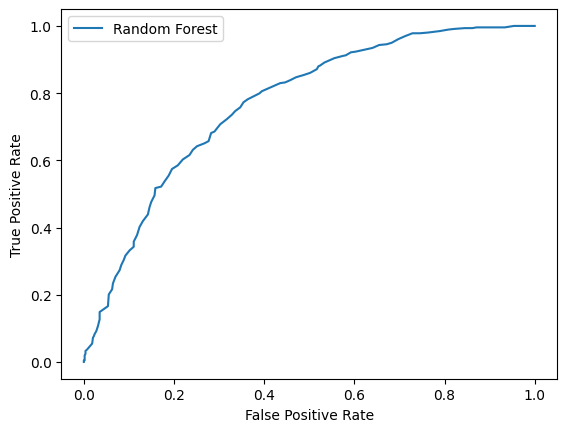

In [ ]:
plt.plot(fpr_forest, tpr_forest, label = "Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

In [ ]:
forest_clf.fit(X_train_reduced_full, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = forest_clf.predict(X_test_reduced_full)
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.4f}")

Random Forest Accuracy: 0.6320


### Support Vector Machine (OvR)

In [ ]:
from sklearn.svm import SVC

svm_clf = SVC(gamma = "auto", random_state = 42, probability = True)
y_probas_svm = cross_val_predict(svm_clf, X_train_reduced_full, y_train, cv = 3, n_jobs = -1, method = "predict_proba")
y_scores_svm = y_probas_svm[:, 1]
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_train, y_scores_svm)

In [ ]:
svm_clf.fit(X_train_reduced_full, y_train)

SVC(gamma='auto', probability=True, random_state=42)

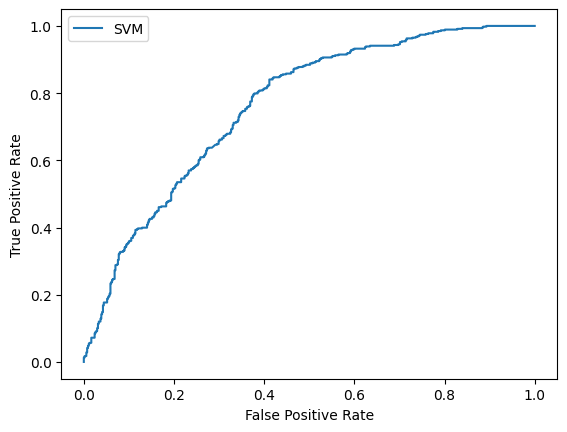

In [ ]:
plt.plot(fpr_svm, tpr_svm, label = "SVM")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

In [ ]:
y_pred = svm_clf.predict(X_test_reduced_full)
accuracy = accuracy_score(y_test, y_pred)
print(f"SVM: {accuracy:.4f}")

SVM: 0.6880


### Multilayer Perceptron (MLP)

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp_clf = MLPClassifier(random_state = 42)
mlp_clf.fit(X_train_reduced_full, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(random_state=42)

In [ ]:
y_probas_mlp = cross_val_predict(mlp_clf, X_train_reduced_full, y_train, cv = 3, n_jobs = -1, method = "predict_proba")
y_scores_mlp = y_probas_mlp[:, 1]
fpr_mlp, tpr_mlp, thresholds_mlp = roc_curve(y_train, y_scores_mlp)

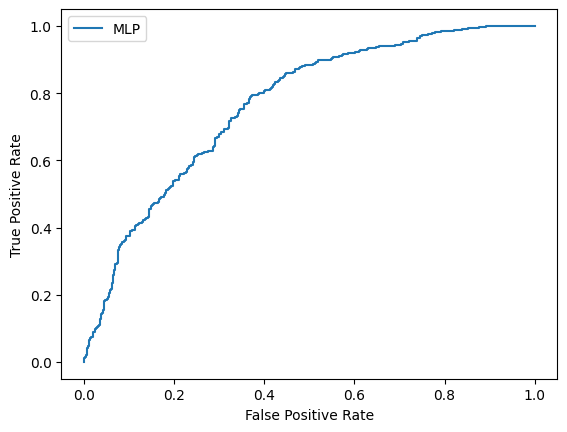

In [ ]:
plt.plot(fpr_mlp, tpr_mlp, label = "MLP")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

In [ ]:
y_pred = mlp_clf.predict(X_test_reduced_full)
accuracy = accuracy_score(y_test, y_pred)
print(f"MLP: {accuracy:.4f}")

MLP: 0.7040


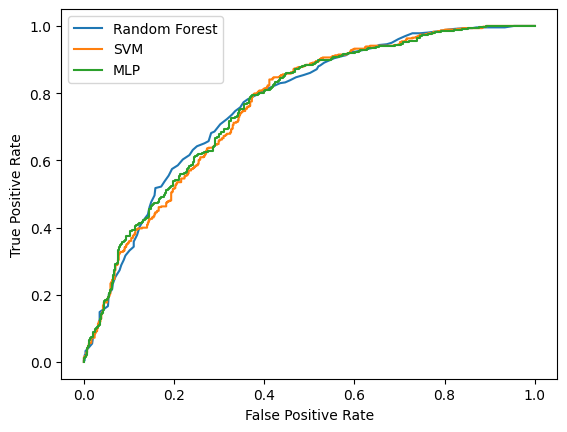

In [ ]:
plt.plot(fpr_forest, tpr_forest, label = "Random Forest")
plt.plot(fpr_svm, tpr_svm, label = "SVM")
plt.plot(fpr_mlp, tpr_mlp, label = "MLP")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

## Subjective Classification

In [ ]:
def pair_labels_subjective(resume_text, job_text):
  prompt = f"""
    You are an expert recruiter for tech-related and cs-related jobs. Given a candidate's skills and a job description's skills,
    compare each list of skills, and return the following:

    0 if the skills are not related.
    1 if the skills are moderately related.
    2 if the skills are closely related.

    Return your answer strictly as either 0, 1, or 2.
  """

  content = f"""
    Resume Skills: {resume_text}
    Job Description Skills: {job_text}
  """

  response = client.models.generate_content(
    model = "gemini-2.5-flash-lite",
    config = types.GenerateContentConfig(
      system_instruction = prompt),
    contents = content,
  )

  score = int(response.text.strip())

  return score

In [ ]:
# filter skills of resume and job descriptions
subjective_api_input = list(zip(cs_tech_resumes[:300]['skill'], cs_tech_jobs[:300]['skills']))
print(subjective_api_input[0])

('Sql server 2005, Sql queries, Sql, Database, Maintenance, R2, Virtualization, Shipping, Stored procedures, Clustering, Backups, Problem solving, T-sql, Sql server 2012, Database administration, Ms sql server, Sql server 2008 r2, Sql server 2008, Sql server, Ms sql server 2005', 'HTML, CSS, JavaScript Frontend frameworks (e.g., React, Angular) User experience (UX)')


In [ ]:
labels_subj = []

total_time = 0
i = 0
for r_skills, j_skills in subjective_api_input:
  start_time = time.time()

  # retries the API call for 2 minutes if the call fail - retries API call on fail after 5 seconds
  while(time.time() - start_time <= 120):
    try:
      labels_subj.append(pair_labels_subjective(r_skills, j_skills))
      end_time = time.time()
      total_time += end_time - start_time
      avg_time = total_time / (i + 1)
      print("execution time: " + str(end_time-start_time) + " total %: " + str(float(i/len(subjective_api_input)*100)) + " predicted total time (m): " + str(avg_time*len(subjective_api_input) / 60))
      i += 1
      break
    except Exception as e:
      print(e)
      time.sleep(30)

execution time: 0.4792156219482422 total %: 0.0 predicted total time (m): 2.396078109741211
execution time: 0.45163607597351074 total %: 0.33333333333333337 predicted total time (m): 2.3271292448043823
execution time: 0.5041797161102295 total %: 0.6666666666666667 predicted total time (m): 2.391719023386637
execution time: 0.42312145233154297 total %: 1.0 predicted total time (m): 2.3226910829544067
execution time: 0.4870429039001465 total %: 1.3333333333333335 predicted total time (m): 2.345195770263672
execution time: 0.4445173740386963 total %: 1.6666666666666667 predicted total time (m): 2.3247609535853067
execution time: 0.4628922939300537 total %: 2.0 predicted total time (m): 2.3232895987374445
execution time: 0.4602687358856201 total %: 2.3333333333333335 predicted total time (m): 2.3205463588237762
execution time: 0.4586806297302246 total %: 2.666666666666667 predicted total time (m): 2.3175304465823703
execution time: 0.4278419017791748 total %: 3.0 predicted total time (m): 

In [ ]:
for i in range(len(subjective_api_input)):
  if(labels_subj[i] == 2):
    print(subjective_api_input[i][0])
    print(subjective_api_input[i][1])
    print(labels_subj[i])

Linux, Excel, Sql, Database, Change management, Sql Database, Sql Dba, Data integration, Extract, transform, and load, databases, Oracle, Integration, Integrator, Etl, Ddl, DBA, Oracle Dba, Encryption, Ms sql server, performance tuning, Rman, Sops, security, Sql server
Proficiency in one or more backend programming languages (e.g., Java, Python, Node.js, Ruby) API development Database management (SQL or NoSQL) Server management and deployment Security best practices Knowledge of web frameworks (e.g., Express, Django)
2
SSRS, System Maintenance, Excel, Database Optimization, Hardware Deployment, Application Support, Data Cleansing, Active Directory, Mac OS, Query Tuning, SQL, Crystal Reports, Database Administration, PowerShell, Data Manipulation, Remote Desktop, Data Warehouse, Troubleshooting, SSIS, Access, Data Validation, Relativity, Automation, Windows OS, Citrix, Backup and Recovery
Data analysis and visualization tools (e.g., Tableau, Power BI) SQL and database querying Business 

### Embeddings for Subjective Classification

In [ ]:
# jobs_skills_all = cs_tech_jobs.loc[:, ["skills"]].astype(str).agg(", ".join, axis = 1)
# jobs_skills_embeddings = model.encode(jobs_skills_all.tolist())

# resumes_skills_all = cs_tech_resumes.loc[:, ["skill"]].astype(str).agg(", ".join, axis = 1)
# resumes_skills_embeddings = model.encode(resumes_skills_all.tolist())

In [ ]:
X = np.array([[int(i)] + list(pair) for i, pair in enumerate(subjective_api_input)])
y = np.array(labels_subj)
X_subj_train, X_subj_test, y_subj_train, y_subj_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [ ]:
from sentence_transformers import util

min_closely_related_sim = 1
min_moderately_related_sim = 1

for train_idx, (i_orig, r_skills, j_skills) in enumerate(X_subj_train):
    embedding1 = model.encode(r_skills.tolist())
    embedding2 = model.encode(j_skills.tolist())

    rel = util.cos_sim(embedding1, embedding2).item()
    if y_subj_train[train_idx] == 2:
        min_closely_related_sim = min(min_closely_related_sim, rel)
    elif y_subj_train[train_idx] == 1:
        min_moderately_related_sim = min(min_moderately_related_sim, rel)

print("Min closely related similarity:", min_closely_related_sim)
print("Min moderately related similarity:", min_moderately_related_sim)

# Min closely related similarity: 0.3471614718437195
# Min moderately related similarity: 0.1584925502538681


Min closely related similarity: 0.306623250246048
Min moderately related similarity: 0.12247296422719955


In [ ]:
# test the embeddings

total_test = len(X_subj_test)
total_correct = 0

for i in range(len(X_subj_test)):
  r_skills = X_subj_test[i][1]
  j_skills = X_subj_test[i][2]

  embedding1 = model.encode(r_skills.tolist())
  embedding2 = model.encode(j_skills.tolist())
  rel = util.cos_sim(embedding1, embedding2).item()
  if(rel >= min_closely_related_sim):
    if(y_subj_test[i] == 2):
      total_correct += 1
  elif(rel >= min_moderately_related_sim):
    if(y_subj_test[i] == 1):
      total_correct += 1
  else:
    if(y_subj_test[i] == 0):
      total_correct += 1

print("Embedding Cosine Similarity Accuracy: " + str(float(total_correct / total_test * 100)))


Embedding Cosine Similarity Accuracy: 31.666666666666664
